# EEG Transformations and Prediction

## Read Data

In [1]:
from scipy.io import loadmat
import numpy as np
import pandas as pd

df = loadmat('dis_data/train/s1D.mat')
matrix = df['DATA']

## Data Cleaning/Transformation

In [2]:
samples,time,channels = matrix.shape
new_mat = np.column_stack((np.repeat(np.arange(channels),time),matrix.reshape(channels*time, -1)))
mat_df = pd.DataFrame(new_mat)

In [3]:
samples = []
for sample, sample_df in mat_df.groupby(mat_df[0]):
    data = pd.DataFrame(sample_df)
    samples.append(data)

for i, j in enumerate(samples):
    pd.DataFrame(samples[i])
    del samples[i][0]
    samples[i].reset_index(drop=True, inplace=True)
    samples[i] = samples[i].T

## Sample Plots

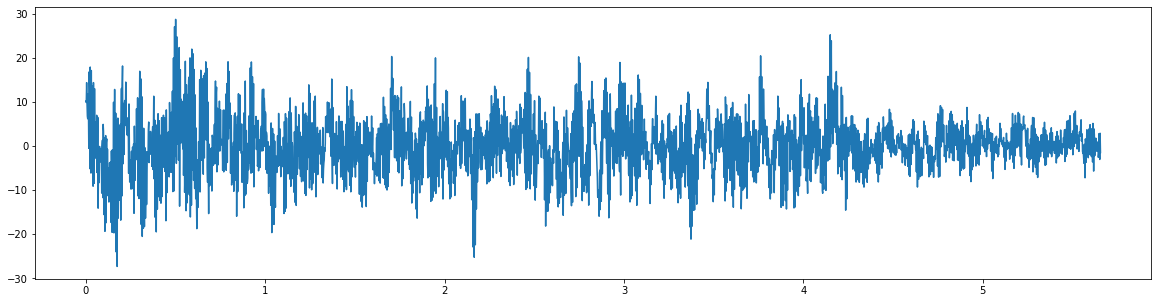

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

sample_rate = 500
num_samples = 2828
seconds = num_samples/sample_rate
time_vect = np.linspace(0, seconds, num_samples)

plt.figure(figsize=(20,5))
plt.plot(time_vect, samples[0].iloc[0])

## Continuous Wavelet Transform

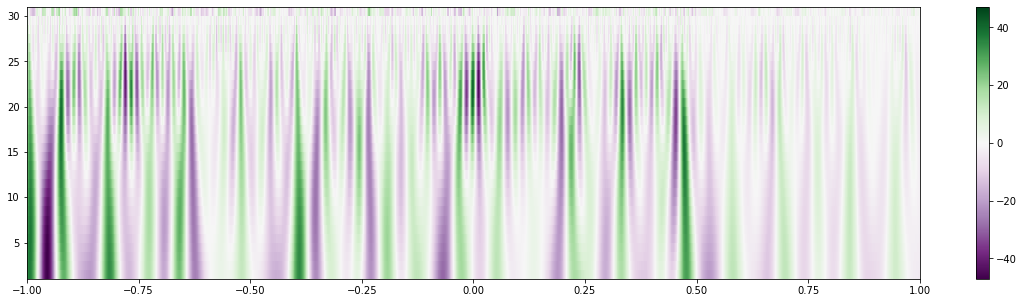

In [5]:
import pywt
from scipy import signal
cwtmatr = signal.cwt(samples[0].iloc[0], signal.ricker, np.arange(1, 31))
plt.figure(figsize=(20,5))
plt.imshow(cwtmatr, extent=[-1, 1, 1, 31], cmap='PRGn', aspect='auto',
           vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
plt.colorbar()
plt.show()

## Hilbert-Huang Transform

### We must perform Empirical Mode Decomposition (EMD) first

In [6]:
import emd
imf = emd.sift.sift(samples[0].iloc[0])

### Compute instantaneous frequency, phase and amplitude using the Normalised Hilbert Transform Method.

In [7]:
IP,IF,IA = emd.spectra.frequency_transform(imf, sample_rate, 'nht')

### Compute Hilbert-Huang spectrum

In [8]:
freq_edges,freq_bins = emd.spectra.define_hist_bins(0,3,30)
hht = emd.spectra.hilberthuang(IF, IA, freq_edges)

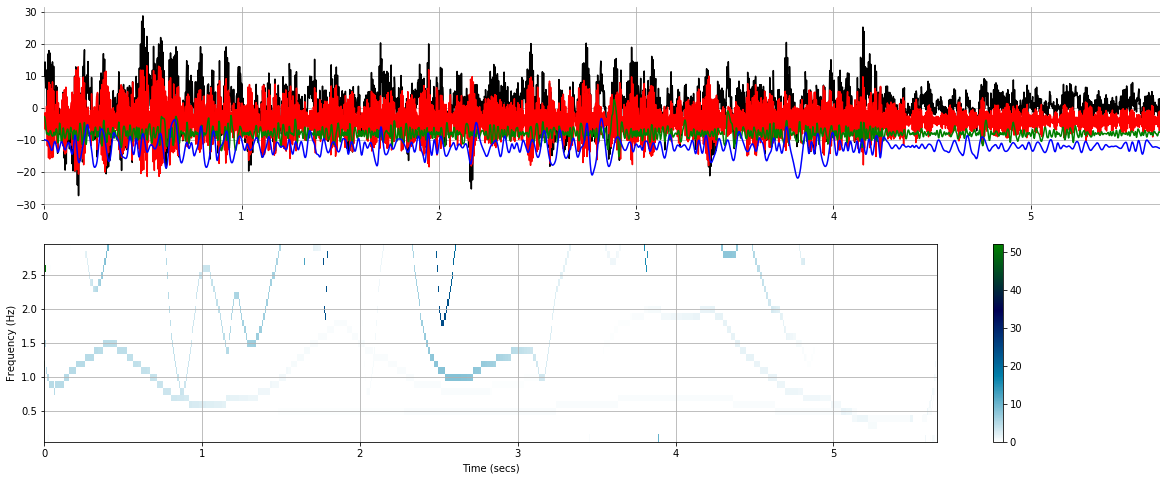

In [9]:
plt.figure(figsize=(20,8))
plt.subplot(2,1,1,frameon=False)
plt.plot(time_vect,samples[0].iloc[0],'k')
plt.plot(time_vect,imf[:,0]-4,'r')
plt.plot(time_vect,imf[:,1]-8,'g')
plt.plot(time_vect,imf[:,2]-12,'b')
plt.xlim(time_vect[0], time_vect[-1])
plt.grid(True)
plt.subplot(2,1,2)
plt.pcolormesh(time_vect, freq_bins, hht, cmap='ocean_r')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (secs)')
plt.grid(True)
plt.colorbar()
plt.show()

# Now, I will perform the same techniques on just one subject. I will input the results into a CNN to train.

## Continuous Wavelet Transform

In [10]:
signals = []
for i, j in enumerate(samples):
    for index, row in samples[i].iterrows():
        cwtmatr = signal.cwt(samples[i].iloc[index-1], signal.ricker, np.arange(1, 31))
        signals.append(cwtmatr)

In [11]:
signals = np.asarray(signals)
signals = np.split(signals, 48)
signals = np.asarray(signals)

In [12]:
from sklearn.decomposition import PCA

sig_comps = []

for i,j in enumerate(signals):
    for k,l in enumerate(signals[i]):
        pca_sigs = PCA(n_components=3)
        comps = pca_sigs.fit_transform(signals[i][k])
        sig_comps.append(comps)

In [13]:
sig_comps = np.array(sig_comps)
sig_comps = np.split(sig_comps, 48)
sig_comps = np.array(sig_comps)

### Create images for each sample

In [14]:
from PIL import Image

signals = np.array(signals, dtype=np.uint8)

for i,j in enumerate(sig_comps):
    img = Image.fromarray(sig_comps[i], 'RGB')
    name = 'img'+str(i)+'.png'
    img.save('/Users/claytonhaley/Desktop/STAT6650/EEG/dis_imgs/CWT/' + str(name))

In [15]:
import glob
imgs = []
for filename in glob.glob('/Users/claytonhaley/Desktop/STAT6650/EEG/dis_imgs/CWT/*.png'):
    img=Image.open(filename)
    img = np.array(img.convert("RGB"))
    imgs.append(img)
imgs = np.array(imgs)

In [16]:
from sklearn.model_selection import train_test_split

labels = loadmat('dis_label/train/sub1DistanceOderNum.mat')
matrix_labels = labels['dist_label']

X_train, X_test, y_train, y_test = train_test_split(imgs, matrix_labels, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

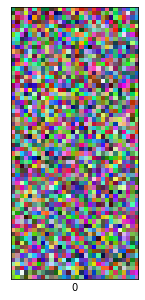

In [17]:
plt.figure(figsize=(5,5))
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(X_train[0], cmap=plt.cm.binary)
plt.xlabel(np.unique(matrix_labels)[y_train[0][0]])
plt.show()

In [32]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(64,30,3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 62, 28, 64)        1792      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 31, 14, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 29, 12, 64)        36928     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 14, 6, 64)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 12, 4, 128)        73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 6, 2, 128)         0         
Total params: 112,576
Trainable params: 112,576
Non-trainable params: 0
________________________________________________

In [33]:
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(2))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 62, 28, 64)        1792      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 31, 14, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 29, 12, 64)        36928     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 14, 6, 64)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 12, 4, 128)        73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 6, 2, 128)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1536)             

In [34]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=50, 
                    validation_data=(X_val, y_val))

Epoch 1/50
1/1 [==============================] - 1s 706ms/step - loss: 2.2371 - accuracy: 0.5714 - val_loss: 132.7261 - val_accuracy: 0.5000
Epoch 2/50
1/1 [==============================] - 0s 96ms/step - loss: 137.9475 - accuracy: 0.4643 - val_loss: 5.4121 - val_accuracy: 0.5000
Epoch 3/50
1/1 [==============================] - 0s 85ms/step - loss: 2.2912 - accuracy: 0.6071 - val_loss: 64.3135 - val_accuracy: 0.5000
Epoch 4/50
1/1 [==============================] - 0s 88ms/step - loss: 58.2020 - accuracy: 0.5357 - val_loss: 35.8471 - val_accuracy: 0.5000
Epoch 5/50
1/1 [==============================] - 0s 90ms/step - loss: 31.9987 - accuracy: 0.5357 - val_loss: 1.2025 - val_accuracy: 0.4000
Epoch 6/50
1/1 [==============================] - 0s 90ms/step - loss: 0.4779 - accuracy: 0.7500 - val_loss: 11.4453 - val_accuracy: 0.5000
Epoch 7/50
1/1 [==============================] - 0s 95ms/step - loss: 11.9264 - accuracy: 0.4643 - val_loss: 1.3081 - val_accuracy: 0.6000
Epoch 8/50
1/1 [

1/1 - 0s - loss: 1.5290 - accuracy: 0.4000


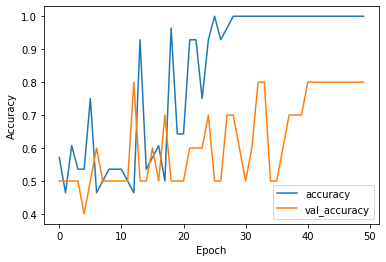

In [35]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,y_test,verbose=2)

## Hilbert Huang Transform

In [36]:
signals_hht = []
for i, j in enumerate(samples):
    for index, row in samples[i].iterrows():
        imf = emd.sift.sift(samples[i].iloc[index-1])
        IP,IF,IA = emd.spectra.frequency_transform(imf, sample_rate, 'nht')
        freq_edges,freq_bins = emd.spectra.define_hist_bins(0,3,30)
        hht = emd.spectra.hilberthuang(IF, IA, freq_edges)
        signals_hht.append(hht)

In [37]:
signals_hht = np.nan_to_num(signals_hht, copy=False, nan=0)

In [38]:
signals_hht = np.asarray(signals_hht)
signals_hht = np.split(signals_hht, 48)
signals_hht = np.asarray(signals_hht)

In [39]:
sig_comps_hht = []

for i,j in enumerate(signals_hht):
    for k,l in enumerate(signals_hht[i]):
        pca_sigs = PCA(n_components=3)
        comps = pca_sigs.fit_transform(signals_hht[i][k])
        sig_comps_hht.append(comps)

In [40]:
sig_comps_hht = np.array(sig_comps_hht)
sig_comps_hht = np.split(sig_comps_hht, 48)
sig_comps_hht = np.array(sig_comps_hht)

In [41]:
signals_hht = np.array(signals_hht, dtype=np.uint8)

for i,j in enumerate(signals_hht):
    img = Image.fromarray(signals_hht[i], 'RGB')
    name = 'img'+str(i)+'.png'
    img.save('/Users/claytonhaley/Desktop/STAT6650/EEG/dis_imgs/HHT/' + str(name))

In [42]:
imgs_hht = []
for filename in glob.glob('/Users/claytonhaley/Desktop/STAT6650/EEG/dis_imgs/HHT/*.png'):
    img=Image.open(filename)
    img = np.array(img.convert("RGB"))
    imgs_hht.append(img)
imgs_hht = np.array(imgs_hht)

In [44]:
labels = loadmat('dis_label/train/sub1DistanceOderNum.mat')
matrix_labels = labels['dist_label']


X_train_hht, X_test_hht, y_train_hht, y_test_hht = train_test_split(imgs_hht, matrix_labels, test_size=0.2, random_state=1)
X_train_hht, X_val_hht, y_train_hht, y_val_hht = train_test_split(X_train_hht, y_train_hht, test_size=0.25, random_state=1)

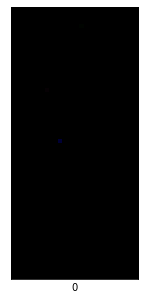

In [45]:
plt.figure(figsize=(5,5))
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(X_train_hht[9], cmap=plt.cm.binary)
plt.xlabel(np.unique(matrix_labels)[y_train_hht[10][0]])
plt.show()

In [46]:
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(64, 30, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 62, 28, 64)        1792      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 31, 14, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 29, 12, 64)        36928     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 14, 6, 64)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 12, 4, 128)        73856     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 6, 2, 128)         0         
Total params: 112,576
Trainable params: 112,576
Non-trainable params: 0
________________________________________________

In [47]:
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(2))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 62, 28, 64)        1792      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 31, 14, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 29, 12, 64)        36928     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 14, 6, 64)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 12, 4, 128)        73856     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 6, 2, 128)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1536)             

In [48]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train_hht, y_train_hht, epochs=50, 
                    validation_data=(X_val_hht, y_val_hht))

Epoch 1/50
1/1 [==============================] - 1s 586ms/step - loss: 1.6630 - accuracy: 0.4286 - val_loss: 8.4873 - val_accuracy: 0.5000
Epoch 2/50
1/1 [==============================] - 0s 93ms/step - loss: 3.7010 - accuracy: 0.5357 - val_loss: 7.0687 - val_accuracy: 0.5000
Epoch 3/50
1/1 [==============================] - 0s 84ms/step - loss: 2.9409 - accuracy: 0.5357 - val_loss: 3.9772 - val_accuracy: 0.5000
Epoch 4/50
1/1 [==============================] - 0s 84ms/step - loss: 1.6294 - accuracy: 0.5357 - val_loss: 1.2755 - val_accuracy: 0.3000
Epoch 5/50
1/1 [==============================] - 0s 83ms/step - loss: 0.5818 - accuracy: 0.6429 - val_loss: 0.7336 - val_accuracy: 0.6000
Epoch 6/50
1/1 [==============================] - 0s 92ms/step - loss: 1.0732 - accuracy: 0.6071 - val_loss: 0.7778 - val_accuracy: 0.6000
Epoch 7/50
1/1 [==============================] - 0s 83ms/step - loss: 1.0768 - accuracy: 0.6071 - val_loss: 0.7134 - val_accuracy: 0.6000
Epoch 8/50
1/1 [==========

1/1 [==============================] - 0s 21ms/step - loss: 0.8748 - accuracy: 0.3000


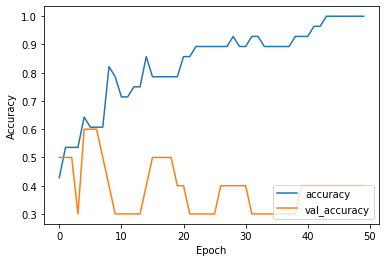

In [49]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test_hht,y_test_hht)